In [98]:
import torch
import torchaudio

import matplotlib.pyplot as plt

from models.sodium import Sodium
from hparams import SODIUM_LARGE_HP, SODIUM_RESNET_HP, SODIUM_TRANSFORMER_HP
from utils.arpabet import ARPABET, ArpabetEncoding, START, END


CUDA_IS_AVAILABLE = torch.cuda.is_available()
print(f"Using {'CUDA' if CUDA_IS_AVAILABLE else 'CPU'} | Audio Backend: {torchaudio.get_audio_backend()}")
if CUDA_IS_AVAILABLE:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Using CUDA | Audio Backend: sox_io


In [2]:
encoding = ArpabetEncoding()
all_singers = [
    "female1",
    "female2",
    "female3",
    "female4",
    "female5",
    "female6",
    "female7",
    "female8",
    "female9",
    "male1",
    "male2",
    "male3",
    "male4",
    "male5",
    "male6",
    "male7",
    "male8",
    "male9",
    "male10",
    "male11",
]
singers2idx = dict(zip(all_singers, range(len(all_singers))))
all_techniques = [
    "belt",
    "breathy",
    "fast_forte",
    "fast_piano",
    "forte",
    "inhaled",
    "lip_trill",
    "messa",
    "pp",
    "slow_forte",
    "slow_piano",
    "spoken",
    "straight",
    "trill",
    "trillo",
    "vibrato",
    "vocal_fry"
]
techniques2idx = dict(zip(all_techniques, range(len(all_techniques))))
vowel2arpabet = {
            "a": "AA",
            "e": "EH",
            "i": "IY",
            "o": "OW",
            "u": "UW"
        }

In [102]:
model = Sodium(
    num_lyrics=len(encoding),
    num_pitches=128,
    num_singers=len(all_singers),
    num_techniques=len(all_techniques),
    **SODIUM_RESNET_HP)
model.to(device)
model.load_state_dict(torch.load("./May30_09-51-30_kaguya/sodium.100.pt"))
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 4477395


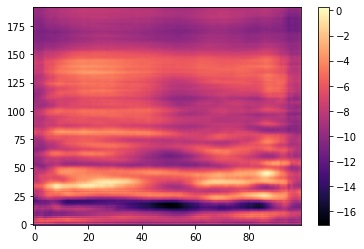

In [103]:
singer = torch.tensor([singers2idx["female6"]], dtype=torch.long, device=device)
technique = torch.tensor([techniques2idx["vibrato"]], dtype=torch.long, device=device)
lyrics = torch.tensor([[encoding.encode(START)] + [encoding.encode(vowel2arpabet[vowel]) for vowel in "aeiuo"] + [encoding.encode(END)]], dtype=torch.long, device=device).transpose(0, 1)
pitches = torch.tensor([[0, 60, 62, 64, 65, 67, 0]], dtype=torch.long, device=device).transpose(0, 1)
durations = torch.tensor([[0, 1, 1, 1, 1, 1, 0]], dtype=torch.float, device=device).transpose(0, 1)
tempo = torch.tensor([120.0], device=device)

model.eval()
output = model.infer(
    singer,
    technique,
    lyrics,
    pitches,
    durations,
    tempo)

im = plt.imshow(output[1].squeeze().cpu().detach().transpose(0, 1), origin='lower', aspect='auto', cmap='magma')
plt.colorbar(im)
plt.show()

In [104]:
torch.save(output[1].squeeze(1), 'aeiuo-resnet.pt')